In [147]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sn
import functions as fn
import functions as fn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [148]:
#View options
#'display.float_format', lambda x: '%8.0f' % x
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [149]:
#Import final polished dataframe
df = pd.read_csv('data/final.csv',encoding='cp1252')

In [150]:
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [151]:
df.shape

(73040, 23)

In [152]:
#Dealing with some missing school size data before transforming
df = df[df.Total_Students.apply(lambda x: x.isnumeric())]

In [153]:
#Transform all numerical data to appropriate datatypes
df['Total_Students'] = df['Total_Students'].astype(int)

In [154]:
#Found some nonsense values in Student/Teacher ratio column, need to replace with 16 (national average)
gibberish = df.loc[df['Student_Teacher_Ratio'] == 'Ã¢â‚¬â€œ']

In [155]:
df['level'] = np.nan

In [156]:
# Enumerate to replace values in ['Level'] to simplify variables
for i, element in enumerate(df['Level']): 
    if element == 'Secondary':
        df['level'][i] = 'High'
    elif element == 'Prekindergarten': 
        df['level'][i] = 'Other'
    elif element == 'Ungraded': 
        df['level'][i] = 'Other'
    elif element == 'Not applicable':
        df['level'][i] = 'Other' 
    else: 
        df['level'][i] = element

<ipython-input-156-3d3f8f40a880>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'][i] = element
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-156-3d3f8f40a880>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'][i] = 'High'
<ipython-input-156-3d3f8f40a880>:10: SettingWithC

In [157]:
df['level'].value_counts()

Elementary    40801
High          16288
Middle        13103
Other          2608
Name: level, dtype: int64

In [158]:
df = df.drop(['Level'], axis=1)

In [159]:
df = df.rename(columns={'level':'Level'})

In [160]:
#Need to fill Nans in Level column

In [161]:
df['Student_Teacher_Ratio'].replace('Ã¢â‚¬â€œ','16',inplace=True)

In [162]:
df = df[df['Student_Teacher_Ratio'] != 'Ã¢â‚¬Â']

In [163]:
df['Student_Teacher_Ratio'].replace('Ã¢â‚¬Â\xa0','16',inplace=True)

In [164]:
df['Student_Teacher_Ratio'] = df['Student_Teacher_Ratio'].astype(float)

In [165]:
# Exploring balance of target classes
df['Target'].value_counts(normalize=True)

0    0.506308
1    0.493692
Name: Target, dtype: float64

In [166]:
#Splitting data into features and target
#Dropping all identifier columns including zipcode - as median income is based on zipcode and is a good stand-in
target = df['Target']
features = df.drop(['School_ID','School_Name','District_Name','District_ID','Zip','City','Target'], axis=1)               

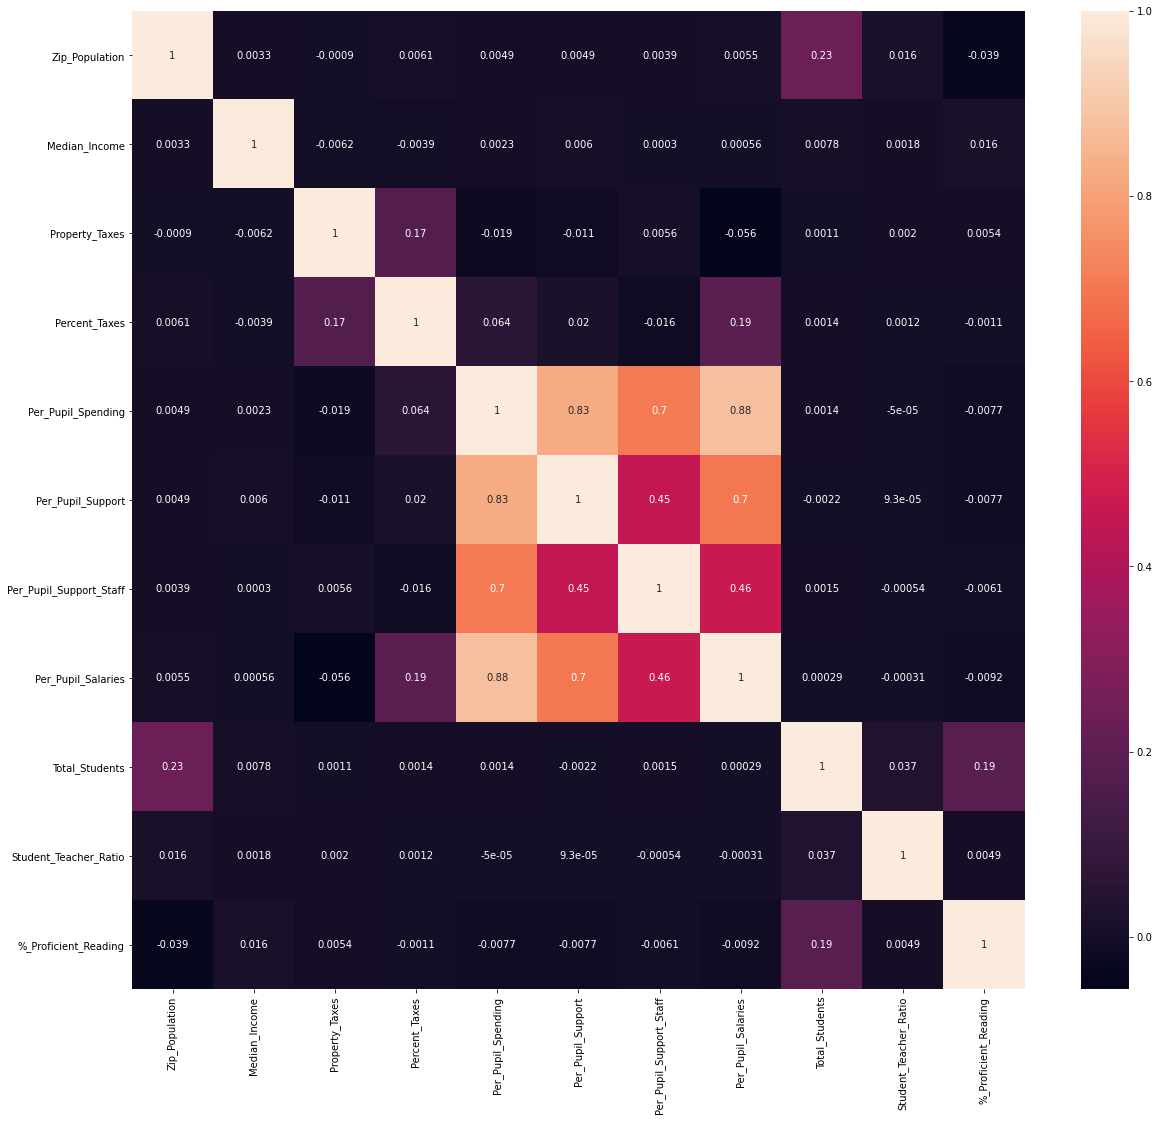

In [167]:
#Exploring multicollinearity
corr = features.corr()
pl.figure(figsize = (20,18))
sn.heatmap(corr, annot=True)
pl.show()

In [168]:
#Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

### Dealing with Categorical Data

In [169]:
features.dtypes

State                       object
Zip_Population               int64
Density                     object
Median_Income                int64
Property_Taxes               int64
Percent_Taxes              float64
Per_Pupil_Spending           int64
Per_Pupil_Support            int64
Per_Pupil_Support_Staff      int64
Per_Pupil_Salaries           int64
Total_Students               int64
Student_Teacher_Ratio      float64
Title_I                     object
Virtual                     object
%_Proficient_Reading         int64
Level                       object
dtype: object

Since there are 50 state possibilities, one-hot encoding would lead to dozens of unnecessary columns. After some thought, I decided to use target encoding to deal with states, using the continuous version of the target to replace each state with the average percentage of students proficient in that state. Though this is an imperfect substitute for location, it is true that states differ markedly from each other in their levels of student achievement and tend to stay consistent from year to year (for example, Massachusetts is continually one of the top-performing states in the nation, while Louisiana is consistently one of the lowest). Thus, treating states this way should feed my model some valuable information about student performance.

In [170]:
#Target encoding state column 
#Create a groupby dataframe that gives us the mean in each numeric column for each state
state_averages = X_train.groupby(['State']).mean().reset_index()

In [171]:
state_averages = state_averages.filter(['%_Proficient_Reading','State'], axis=1).rename(columns={'%_Proficient_Reading':'State_Avg_Reading'})


In [172]:
#Join state helper dataframe with my training predictors and testing data
X_train = pd.merge(state_averages, X_train, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)
X_test = pd.merge(state_averages, X_test, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)

In [173]:
X_train.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level
0,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,39,4.18,yes,no,NaN
1,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,48,4.05,yes,no,NaN
2,35.559524,45366,midsize,61089,989357,47.9,10173,392,1145,3257,198,9.66,yes,yes,Elementary
3,35.559524,107571,urban,62602,6090,41.4,9813,581,616,3995,321,12.07,yes,yes,Elementary
4,35.559524,12114,midsize,47060,7640,36.2,13364,661,223,4595,280,15.56,yes,yes,Elementary


In [174]:
#Deal with nulls in training and testing data
X_train = X_train.fillna(value = {"Level":"Other"})
X_test = X_test.fillna(value = {'Level':'Other'})

In [175]:
#Putting X back together
X = pd.concat([X_train, X_test], axis=0)

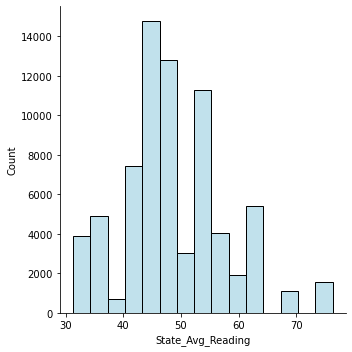

In [176]:
sn.displot(X, x='State_Avg_Reading', binwidth=3, color="lightblue")
pl.savefig("State Averages")

In [177]:
#Now need to one-hot encode  categorical columns
#Isolate categorical columns
cats = X[['Density','Title_I', 'Virtual','Level']]
#Transform data
cats = pd.get_dummies(cats)

In [178]:
cats.head()

,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,1,0,0,1,1,0,0,0,0,1
1,1,0,0,1,1,0,0,0,0,1
2,1,0,0,1,0,1,1,0,0,0
3,0,1,0,1,0,1,1,0,0,0
4,1,0,0,1,0,1,1,0,0,0


In [179]:
#Merge with main dataframe on key values
X_numeric = pd.concat([X, cats], axis=1)

In [180]:
X_numeric.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,39,4.18,yes,no,Other,1,0,0,1,1,0,0,0,0,1
1,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,48,4.05,yes,no,Other,1,0,0,1,1,0,0,0,0,1
2,35.559524,45366,midsize,61089,989357,47.9,10173,392,1145,3257,198,9.66,yes,yes,Elementary,1,0,0,1,0,1,1,0,0,0
3,35.559524,107571,urban,62602,6090,41.4,9813,581,616,3995,321,12.07,yes,yes,Elementary,0,1,0,1,0,1,1,0,0,0
4,35.559524,12114,midsize,47060,7640,36.2,13364,661,223,4595,280,15.56,yes,yes,Elementary,1,0,0,1,0,1,1,0,0,0


In [181]:
#Drop non-numeric categorical columns 
X_numeric = X_numeric.drop(['Density','Title_I', 'Virtual','Level'], axis=1)

In [182]:
X_numeric.head()

,State_Avg_Reading,Zip_Population,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,35.559524,1410,72188,7518,35.6,10545,389,438,4049,39,4.18,1,0,0,1,1,0,0,0,0,1
1,35.559524,1410,72188,7518,35.6,10545,389,438,4049,48,4.05,1,0,0,1,1,0,0,0,0,1
2,35.559524,45366,61089,989357,47.9,10173,392,1145,3257,198,9.66,1,0,0,1,0,1,1,0,0,0
3,35.559524,107571,62602,6090,41.4,9813,581,616,3995,321,12.07,0,1,0,1,0,1,1,0,0,0
4,35.559524,12114,47060,7640,36.2,13364,661,223,4595,280,15.56,1,0,0,1,0,1,1,0,0,0


In [183]:
#Have to re-do the train test split
X_train, X_test, y_train, y_test = train_test_split(X_numeric, target, test_size=0.20, random_state=42)

### Scaling Data

In [184]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train, y=None)
X_test_scaled = scaler.transform(X_test)

### Baseline Modeling

Schools with below 50% proficiency) comprise the majority class. Could a baseline model do better than that?  

In [185]:
train = X_train.copy()
train['target'] = y_train.values

In [186]:
test = X_test
test['target'] = y_test

<ipython-input-186-fd87e67f2ec4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = y_test


In [187]:
len(train) + len(test)

72920

In [188]:
# Make baseline dataframe 
bdf = pd.concat([train,test],axis=0)

In [189]:
# Number correct is number of proficient districts with state proficiency > 50%
# and non-proficient districts with state proficiency < 50%.
prof_correct = len(bdf[(bdf['State_Avg_Reading']>50) & (bdf['target']==1)])
notprof_correct = len(bdf[(bdf['State_Avg_Reading']<50) & (bdf['target']==0)])

# Add totals
correct = prof_correct + notprof_correct
print(f'Baseline accuracy based on average statewide reading proficiency: {correct/len(bdf):.2}')

Baseline accuracy based on average statewide reading proficiency: 0.42


So a model that predicts a district's reading proficiency based on the overall average proficiency for the state in which the school is located only predicts correctly 42% of the time. We're better off just randomly guessing that a district is proficient!

### Logistic Regression Model

In [190]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [191]:
logreg.score(X_train_scaled, y_train)

0.5067539769610532

In [192]:
logreg.score(X_test_scaled, y_test)

0.4943773998902907

First logistic regression model did slightly better than baseline model, but still worse than randomly guessing the majority class. Hopefully our other classifier models can perform better. 

### K-Nearest Neighbors Model

In [193]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
#Predictions for the testing set
y_preds = knn.predict(X_test_scaled)

In [194]:
#fn.evaluate(knn, X_train_scaled, X_test_scaled, y_train, y_test)

Overfitting appears to be a significant problem; training data does OK but precision score drops a ton on testing. Before turning to feature engineering or a grid search, I'm going to try a couple of other models to see how well they perform comparatively. 

### Random Forest Model

In [195]:
rf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled) 

Train Scores
------------
Accuracy: 0.5435922929237521
Precision: 0.5801586293328131
F1 Score: 0.27921708763095915
ROC-AUC: 0.5814010905846668
--------------------
Test Scores
-----------
Accuracy: 0.5049369171695008
Precision: 0.5022952197919238
F1 Score: 0.21996542783059636
ROC-AUC: 0.5080112862860133


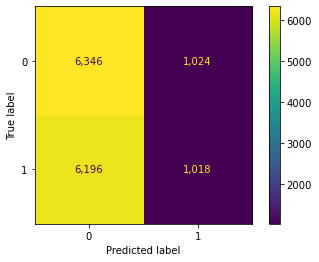

In [196]:
fn.evaluate(rf, X_train_scaled, X_test_scaled, y_train, y_test)

This has reduced overfitting somewhat, but precision has stayed mostly the same and is still about as accurate as random guessing.

### Gradient Boosting Model

In [197]:
#Trying sklearn gradient boosting instead
gbmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1, random_state=0).fit(X_train_scaled, y_train)

In [198]:
gbmodel_preds = gbmodel.predict(X_test_scaled)

Train Scores
------------
Accuracy: 0.5311300054854635
Precision: 0.5317051846741114
F1 Score: 0.4520833333333333
ROC-AUC: 0.54350613424485
--------------------
Test Scores
-----------
Accuracy: 0.505759736697751
Precision: 0.5047068330570754
F1 Score: 0.425931825422109
ROC-AUC: 0.5034476532326898


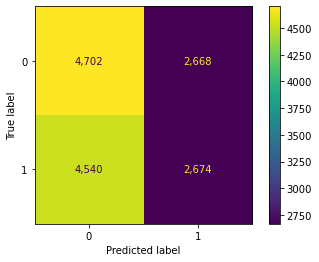

In [199]:
fn.evaluate(gbmodel, X_train_scaled, X_test_scaled, y_train, y_test)

Using gradient boosting did not appear to have any discernible improvement for my model. However, the gap in precision scores between training and testing models was the smallest here out of any of the three algorithms.

### AdaBoost Classifier

In [200]:
ada = AdaBoostClassifier()
ada.fit(X_train_scaled, y_train)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.5242731760833791
Precision: 0.5246260599232768
F1 Score: 0.4314512824715234
ROC-AUC: 0.5346677947766252
--------------------
Test Scores
-----------
Accuracy: 0.5072682391662096
Precision: 0.5062378712993225
F1 Score: 0.41204385534282445
ROC-AUC: 0.505746157686001


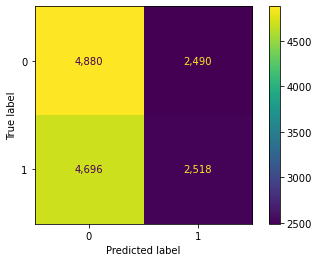

In [201]:
fn.evaluate(ada, X_train_scaled, X_test_scaled, y_train, y_test)

### Feature Engineering and Model Improvement

In [202]:
importances = rf.feature_importances_

In [203]:
feature_names = X_test.drop(labels='target', axis=1)

In [204]:
rf_importances = pd.DataFrame(index=feature_names.columns, data=importances).sort_values(by=0,ascending=False)

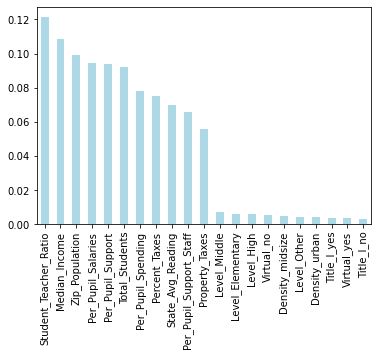

In [205]:
# plot feature importance
rf_importances.plot(kind='bar', legend=False, color='lightblue');

As a first try, I'm going to select only the top eight features with an importance of over .06 and rerun the models to see if these improve precision scores. As an added bonus, this feature selection might make my models more interpretable. Since my gradient boosting model seemed the most effective when it came to minimizing overfitting, I will re-run this algorithm on my new features.

In [206]:
top8_X_numeric = X_numeric[['Student_Teacher_Ratio','Median_Income','Zip_Population','Per_Pupil_Salaries','Per_Pupil_Support','Total_Students','Per_Pupil_Spending','Percent_Taxes']]



In [207]:
#Have to re-do the train test split
top8_X_train, top8_X_test, y_train, y_test = train_test_split(X_numeric, target, test_size=0.20, random_state=42)

In [208]:
#Scale the data again
top8_X_train_scaled = scaler.fit_transform(top8_X_train, y=None)
top8_X_test_scaled = scaler.transform(top8_X_test)

In [209]:
#Run Gradient Boosting 
top8_gbmodel = GradientBoostingClassifier(n_estimators=100,
max_depth=1, random_state=0).fit(top8_X_train_scaled, y_train)

In [210]:
top8_gbmodel_preds = top8_gbmodel.predict(top8_X_test_scaled)

Train Scores
------------
Accuracy: 0.5149993143170598
Precision: 0.5172668979751646
F1 Score: 0.3001459420684196
ROC-AUC: 0.5249659339242155
--------------------
Test Scores
-----------
Accuracy: 0.5054168952276468
Precision: 0.5034960439338292
F1 Score: 0.29096628329892854
ROC-AUC: 0.5108552776355639


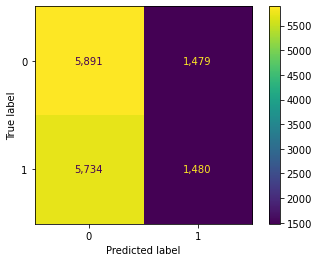

In [211]:
fn.evaluate(top8_gbmodel, top8_X_train_scaled, top8_X_test_scaled, y_train, y_test)

Selecting features had no discernible effect on my model. Going to try tuning some of the more important hyperparameters next, such as learning rate.

In [212]:
X_numeric.shape

(72920, 21)

In [213]:
#Seeing how models performs with default parameters
default = GradientBoostingClassifier().fit(top8_X_train_scaled, y_train)

In [214]:
default_preds = default.predict(top8_X_test_scaled)

Train Scores
------------
Accuracy: 0.5555231760833791
Precision: 0.5599924615875593
F1 Score: 0.4609915809167446
ROC-AUC: 0.5865065334800958
--------------------
Test Scores
-----------
Accuracy: 0.5063082830499177
Precision: 0.5051731051550702
F1 Score: 0.4103194103194103
ROC-AUC: 0.5101893310873362


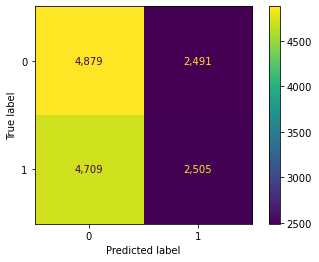

In [215]:
fn.evaluate(default, top8_X_train_scaled, top8_X_test_scaled, y_train, y_test)


With default parameters, precision score went up slightly (by .02%); however, overfitting also worsened slightly. Going to try a GridSearch CV next. 

loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0

In [216]:
X_numeric.shape

(72920, 21)

**min_samples_split = 700**: min_samples should be ~.05 - 1% of total values. Since this is a balanced class problem, will take towards the larger end of the range. 1% of 72920 is about 700.

**max_depth = 7**: Should be chosen (5-8) based on the number of observations and predictors. This has 72K rows and 21 columns so lets take 7 here.

**max_features = sqrt**: Rule of thumb.

**subsample == 0.8**: Commonly used start value.

In [217]:
#Creating scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter
parameters = {
    "min_samples_split": [100],
    "max_depth":[7],
    "max_features":["sqrt"],
    "subsample":[0.8],
    "n_estimators":range(20,81,10)
    }
#Passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)

clf.fit(top8_X_train_scaled, y_train)
#Converting the clf.cv_results to dataframe
results=pd.DataFrame.from_dict(clf.cv_results_)
#Here are inputs for cross validation is cv=2, there two split split0 and split1
results[['split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_recall','split1_test_recall']]

,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_recall,split1_test_recall
0,0.504731,0.504320,0.497456,0.496947,0.359967,0.367609
1,0.502263,0.499246,0.494511,0.490111,0.391232,0.366706
2,0.496949,0.499931,0.488168,0.491700,0.401306,0.397207
3,0.501234,0.502331,0.493316,0.494826,0.397415,0.408671
4,0.500171,0.501269,0.492390,0.493615,0.418050,0.413604
5,0.499177,0.503394,0.491447,0.496262,0.429167,0.424303
6,0.501646,0.502091,0.494235,0.494783,0.425901,0.428333


In [218]:
#find the best parameter based on the accuracy_score
#taking the average of the precision
results['precision_score']=(results['split0_test_precision']+results['split1_test_precision'])/2

results.loc[results['precision_score'].idxmax()]['params']

{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 100,
 'n_estimators': 20,
 'subsample': 0.8}

### Adding More Data

Since the gridsearches did not work to improve the model's performance significantly, I'm going to try adding in some additional features to the model to see if that improves the score.

In [219]:
money = pd.read_csv('data/sdf19_1a.txt',sep="\t")

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [220]:
money.shape

(19700, 262)

In [221]:
df['District_ID'] = df['District_ID'].astype(str)

In [222]:
addtl_features = money[['LEAID','TOTALREV','TFEDREV','TSTREV','TLOCREV','T40','Z32','Z33']]

In [223]:
addtl_features = addtl_features.rename({'LEAID':'District_ID', 'TOTALREV':'Total_Revenue','TFEDREV':'Federal_Revenue','TSTREV':'State_Revenue','TLOCREV':'Local_Revenue','T40':'Income_Taxes','Z32':'Total_Salaries','Z33':'Instructional_Salaries'
                                       },axis=1)

In [224]:
df2 = df.merge(addtl_features, on='District_ID', how='inner')

In [225]:
df2.head()

,School_ID,School_Name,District_Name,District_ID,City,State,Zip,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,%_Proficient_Reading,Target,Level,Total_Revenue,Federal_Revenue,State_Revenue,Local_Revenue,Income_Taxes,Total_Salaries,Instructional_Salaries
0,NC-32M-000,Global Scholars Academy,AUTAUGA COUNTY SCHOOL DISTRICT,3700316,Durham,NC,27701,63864,midsize,41566,7637,8.7,8600,512,241,3357,206,11.31,yes,no,30,0,Elementary,2855000,320000,1506000,1029000,-2,1875000,1165000
1,NC-320-310,Eastway Elementary,LOS ANGELES UNIF SCH DIST,3701260,Durham,NC,27701,63864,midsize,41566,2411346,24.4,15793,969,1189,5023,439,11.31,yes,no,11,0,Elementary,413911000,45699000,213378000,154834000,-2,247872000,166724000
2,NC-320-347,George Watts Elementary,WHITTIER CY SCHOOL DISTRICT,3701260,Durham,NC,27701,63864,midsize,41566,15097,18.2,12453,588,825,4813,363,11.86,yes,no,55,1,Elementary,413911000,45699000,213378000,154834000,-2,247872000,166724000
3,NC-320-323,Durham School of the Arts,CHARLES CO SCHS,3701260,Durham,NC,27701,63864,midsize,41566,0,46.0,14732,786,738,5595,1869,16.78,yes,yes,68,1,High,413911000,45699000,213378000,154834000,-2,247872000,166724000
4,NC-320-308,Burton Elementary,DANIEL MORGAN AREA VOCATIONAL CENTER,3701260,Durham,NC,27701,63864,midsize,41566,0,0.0,0,0,0,0,339,10.59,yes,no,40,0,Elementary,413911000,45699000,213378000,154834000,-2,247872000,166724000


### Transforming Dataframe with Additional Features 

In [226]:
#Splitting data into features and target
#Dropping all identifier columns including zipcode - as median income is based on zipcode and is a good stand-in
target2 = df2['Target']
features2 = df2.drop(['School_ID','School_Name','District_Name','District_ID','Zip','City','Target'], axis=1)               

In [227]:
#Performing train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.20, random_state=42)

In [228]:
#Join state helper dataframe with my training predictors and testing data
X_train2 = pd.merge(state_averages, X_train2, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)
X_test2 = pd.merge(state_averages, X_test2, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)

In [229]:
X_train2.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level,Total_Revenue,Federal_Revenue,State_Revenue,Local_Revenue,Income_Taxes,Total_Salaries,Instructional_Salaries
0,33.409396,45996,midsize,49871,989357,47.9,10173,392,1145,3257,902,13.56,no,no,Elementary,1526358000,132899000,0,1393459000,-2,753686000,431471000
1,33.409396,157110,urban,98071,231098,19.2,13175,687,696,4720,399,12.00,yes,no,Elementary,1526358000,132899000,0,1393459000,-2,753686000,431471000
2,33.409396,34530,midsize,104802,3595,27.2,10928,340,395,5608,229,13.47,yes,no,Elementary,5614000,399000,0,5215000,-2,2390000,1487000
3,33.409396,50682,midsize,63060,6380,16.6,9999,906,594,3395,234,10.58,yes,no,Elementary,103320000,9720000,0,93600000,-2,52235000,31065000
4,33.409396,175608,urban,66151,142245,50.4,9183,531,534,4448,517,10.77,yes,no,Elementary,1526358000,132899000,0,1393459000,-2,753686000,431471000


In [230]:
#Deal with nulls in training and testing data
X_train2 = X_train2.fillna(value = {"Level":"Other"})
X_test2 = X_test2.fillna(value = {'Level':'Other'})

In [231]:
#Putting X back together
X2 = pd.concat([X_train2, X_test2], axis=0)

In [232]:
#Now need to one-hot encode  categorical columns
#Isolate categorical columns
cats2 = X2[['Density','Title_I', 'Virtual','Level']]
#Transform data
cats2 = pd.get_dummies(cats2)

In [233]:
#Merge with main dataframe on key values
X_numeric2 = pd.concat([X2, cats2], axis=1)

In [234]:
#Drop non-numeric categorical columns 
X_numeric2 = X_numeric2.drop(['Density','Title_I', 'Virtual','Level'], axis=1)

In [235]:
#Have to re-do the train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_numeric2, target2, test_size=0.20, random_state=42)

### Scaling Data Again

In [236]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled2 = scaler.fit_transform(X_train2, y=None)
X_test_scaled2 = scaler.transform(X_test2)

### Logistic Regression Model with Additional Features

In [237]:
logreg = LogisticRegression()
logreg.fit(X_train2, y_train2)

LogisticRegression()

In [238]:
logreg.score(X_train_scaled2, y_train2)

0.5107304587517227

In [239]:
logreg.score(X_test_scaled2, y_test2)

0.5124015748031496

### KNN Model with Additional Features

In [240]:
knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(X_train_scaled2, y_train2)
#Predictions for the testing set
y_preds = knn2.predict(X_test_scaled2)

Train Scores
------------
Accuracy: 0.7498523331364442
Precision: 0.749829509138341
F1 Score: 0.7379872138585276
ROC-AUC: 0.8121905865513442
--------------------
Test Scores
-----------
Accuracy: 0.5094488188976378
Precision: 0.5092663650252673
F1 Score: 0.48298755186721987
ROC-AUC: 0.5120471633629529


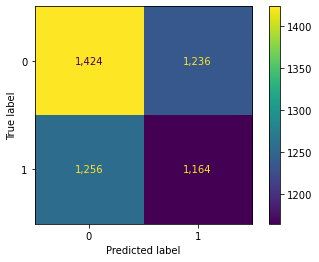

In [241]:
fn.evaluate(knn2, X_train_scaled2, X_test_scaled2, y_train2, y_test2)

### Random Forest Model with Additional Features

In [242]:
rf2 = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf2.fit(X_train_scaled2, y_train2)
rf_preds2 = rf2.predict(X_test_scaled2) 

Train Scores
------------
Accuracy: 0.5548828509549124
Precision: 0.5858095450878199
F1 Score: 0.2612531655910465
ROC-AUC: 0.6048140999240819
--------------------
Test Scores
-----------
Accuracy: 0.5301181102362205
Precision: 0.5281235426036873
F1 Score: 0.22424439389015272
ROC-AUC: 0.5329780805319083


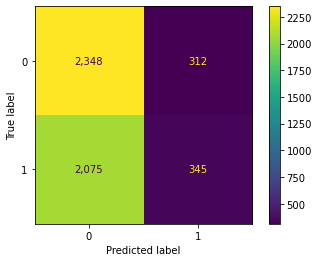

In [243]:
fn.evaluate(rf2, X_train_scaled2, X_test_scaled2, y_train2, y_test2)

### Gradient Boosting Model with Additional Features

In [244]:
gbmodel2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1, random_state=0).fit(X_train_scaled2, y_train2)

In [245]:
gbmodel_preds2 = gbmodel2.predict(X_test_scaled2)

Train Scores
------------
Accuracy: 0.5571470761961016
Precision: 0.5566057591183537
F1 Score: 0.4447324569524162
ROC-AUC: 0.5815591883516176
--------------------
Test Scores
-----------
Accuracy: 0.5240157480314961
Precision: 0.5186261682717103
F1 Score: 0.4020771513353116
ROC-AUC: 0.5241165413533835


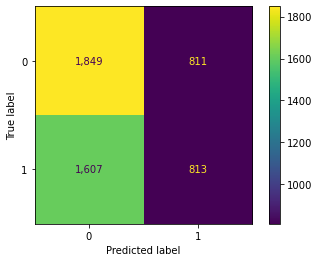

In [246]:
fn.evaluate(gbmodel2, X_train_scaled2, X_test_scaled2, y_train2, y_test2)

### AdaBoost Model with Additional Features

In [247]:
ada2 = AdaBoostClassifier()
ada2.fit(X_train_scaled2, y_train2)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.5502067336089781
Precision: 0.5492611624899076
F1 Score: 0.4236881937436932
ROC-AUC: 0.5674570173048243
--------------------
Test Scores
-----------
Accuracy: 0.5271653543307087
Precision: 0.5216470421977416
F1 Score: 0.38347022587269
ROC-AUC: 0.5253327533710308


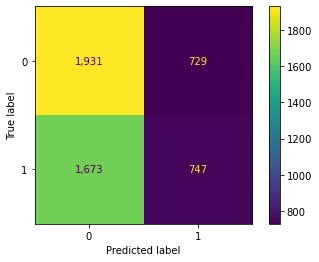

In [248]:
fn.evaluate(ada2, X_train_scaled2, X_test_scaled2, y_train2, y_test2)

### Feature Importances with Additional Features

In [249]:
importances2 = rf2.feature_importances_

In [250]:
rf_importances2 = pd.DataFrame(index=X_test2.columns, data=importances2).sort_values(by=0,ascending=False)

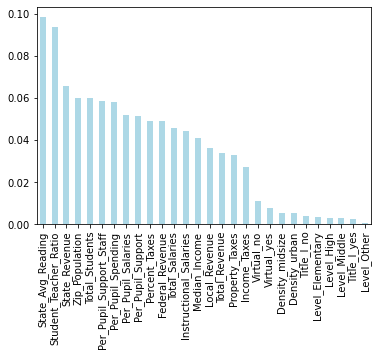

In [251]:
# plot feature importance
rf_importances2.plot(kind='bar', legend=False, color='lightblue');

### Logistic Regression Model Tuning

In [252]:
# Perform GridSearchCV to tune best-fit LR model
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model3 = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model3, param_grid=param)
gs_model.fit(X_train_scaled2, y_train2)

# Train a LR model with best parameters
model3 = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model3.fit(X_train_scaled2, y_train2)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [253]:
model3.score(X_train_scaled2, y_train2)

0.52766292577279

In [254]:
logreg.score(X_test_scaled2, y_test2)

0.5124015748031496

In [255]:
coef = model3.coef_[0]
coef

array([ 3.17705325e-02, -5.01090612e-03, -8.53456533e-03, -1.78889040e-02,
        1.34111722e-02, -2.73833887e-02,  2.88457283e-02,  6.79021482e-03,
       -2.35984491e-03, -2.25797309e-02, -1.35684604e-02,  0.00000000e+00,
       -7.79715219e-02,  1.50782627e-02, -8.13222510e-02,  4.95428171e-03,
       -3.84500397e-01,  5.03620460e-01,  1.86753217e-04, -3.12324479e-02,
        1.12160011e-04, -6.82200966e-03, -6.23073439e-07,  3.57531623e-02,
       -2.78212149e-03,  0.00000000e+00,  3.18343783e-03, -9.51384373e-03])

In [256]:
coef = model3.coef_[0]
imp_features = pd.Series(X_test2.columns)[list(coef!=0)]
X_train3 = X_train2[imp_features]
X_test3 = X_test2[imp_features]

In [257]:
print('Redundant Feature Names:', list(pd.Series(X_test2.columns[list(coef==0)])))

Redundant Feature Names: ['Total_Revenue', 'Level_High']


In [258]:
# Trying logistic regression model without redundant features
X_train_scaled3 = scaler.fit_transform(X_train2, y=None)
X_test_scaled3 = scaler.transform(X_test2)

In [259]:
logreg3 = LogisticRegression()
logreg3.fit(X_train_scaled3, y_train2)

LogisticRegression()

In [260]:
logreg.score(X_train_scaled3, y_train2)

0.5107304587517227

In [261]:
logreg.score(X_test_scaled3, y_test2)

0.5124015748031496

### Adding Even More Data

Since I'm not having a lot of luck with adding just a handful of features that I think are the most important, I'm going to add in all of the financial data I currently have to see if that improves my model. 

In [262]:
money.head()

,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,AGCHRT,YEAR,CCDNF,CENFILE,GSLO,GSHI,V33,MEMBERSCH,TOTALREV,TFEDREV,C14,C15,C16,C17,C19,B11,C20,C25,C36,B10,B12,B13,TSTREV,C01,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C35,C38,C39,TLOCREV,T02,T06,T09,T15,T40,T99,D11,D23,A07,A08,A09,A11,A13,A15,A20,A40,U11,U22,U30,U50,U97,C24,TOTALEXP,TCURELSC,TCURINST,E13,V91,V92,TCURSSVC,E17,E07,E08,E09,V40,V45,V90,V85,TCUROTH,E11,V60,V65,TNONELSE,V70,V75,V80,TCAPOUT,F12,G15,K09,K10,K11,L12,M12,Q11,I86,Z32,Z33,Z35,Z36,Z37,Z38,V11,V13,V15,V17,V21,V23,V37,V29,Z34,V10,V12,V14,V16,V18,V22,V24,V38,V30,V32,V93,_19H,_21F,_31F,_41F,_61V,_66V,W01,W31,W61,V95,V02,K14,CE1,CE2,CE3,WEIGHT,FL_V33,FL_MEMBERSCH,FL_C14,FL_C15,FL_C16,FL_C17,FL_C19,FL_B11,FL_C20,FL_C25,FL_C36,FL_B10,FL_B12,FL_B13,FL_C01,FL_C04,FL_C05,FL_C06,FL_C07,FL_C08,FL_C09,FL_C10,FL_C11,FL_C12,FL_C13,FL_C35,FL_C38,FL_C39,FL_T02,FL_T06,FL_T09,FL_T15,FL_T40,FL_T99,FL_D11,FL_D23,FL_A07,FL_A08,FL_A09,FL_A11,FL_A13,FL_A15,FL_A20,FL_A40,FL_U11,FL_U22,FL_U30,FL_U50,FL_U97,FL_C24,FL_E13,FL_V91,FL_V92,FL_E17,FL_E07,FL_E08,FL_E09,FL_V40,FL_V45,FL_V90,FL_V85,FL_E11,FL_V60,FL_V65,FL_V70,FL_V75,FL_V80,FL_F12,FL_G15,FL_K09,FL_K10,FL_K11,FL_L12,FL_M12,FL_Q11,FL_I86,FL_Z32,FL_Z33,FL_Z35,FL_Z36,FL_Z37,FL_Z38,FL_V11,FL_V13,FL_V15,FL_V17,FL_V21,FL_V23,FL_V37,FL_V29,FL_Z34,FL_V10,FL_V12,FL_V14,FL_V16,FL_V18,FL_V22,FL_V24,FL_V38,FL_V30,FL_V32,FL_V93,FL_19H,FL_21F,FL_31F,FL_41F,FL_61V,FL_66V,FL_W01,FL_W31,FL_W61,FL_V95,FL_V02,FL_K14,FL_CE1,FL_CE2,FL_CE3
0,100002,N,1,1073,142,13820,Alabama Youth Services,Alabama,AL,N,N,19,1,0,03,12,-2,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-2,-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,N,N,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,N,N,N,N,N,N,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M
1,100005,01504840100000,1,1095,290,10700,Albertville City,Alabama,AL,03,3,19,1,1,PK,12,5636,5636,60116000,7939000,2439000,1134000,240000,0,101000,103000,412000,3467000,0,0,0,43000,36177000,29411000,78000,0,293000,97000,0,0,0,1555000,2275000,2468000,0,0,0,16000000,-2,5787000,0,0,0,430000,17000,5400000,93000,0,232000,0,1631000,0,366000,122000,78000,345000,2000,131000,1366000,0,55237000,49715000,28612000,28612000,0,0,17262000,3619000,1453000,1470000,2652000,4401000,2796000,871000,0,3841000,3841000,0,0,949000,150000,198000,601000,2750000,2351000,0,120000,279000,0,0,0,86000,1737000,26349000,16897000,13210000,838000,1089000,505000,2091000,794000,752000,1842000,1014000,1308000,530000,929000,10588000,6508000,780000,293000,219000,686000,458000,878000,163000,555000,0,395000,28876000,2017000,2634000,28259000,0,0,9516000,738000,8987000,1085000,0,0,-1,-1,0,1,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,M,M,M,R,R,R,R,M,M,N,R,M,M,M,R,R,R,R,M,R,R,R,R,R,R,R,R,R,R,R,R,R,R,M,R,R,R,R,R,R,R,R,R,M,M,R,R,R,R,R,R,R,R,M,M,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,M,R,A,R,R,I,M,M,R,R,R,R,M,M,M,M,M
2,100006,01504800100000,1,1095,290,10700,Marshall County,Alabama,AL,03,3,19,1,1,PK,12,5652,5652,61936000,7953000,2758000,1465000,386000,0,145000,51000,331000,2817000,0,0,0,0,40042000,30760000,65000,0,552000,42000,0,0,0,1642000,3434000,3547000,0,0,0,13941000,-2,7162000,0,0,0,10000,0,2054000,14000,0,575000,0,1495000,0,324000,1000,489000,209000,5000,535000,1068000,0,60022000,58351000,30884000,30884000,7000,0,23015000,4095000,1849000,2074000,3902000,5986000,3929000,1180000,0,4452000,4452000,0,0,724000,64000,167000,493000,266000,0,48000,65000,153000,0,0,0,48000,626000,32647000,19574000,13204000,1913000,1277000,772000,2618000,909000,1105000,2727000,1636000,2057000,508000,1370000,13208000,7529000,942000

In [263]:
cols = [c for c in money.columns if c.lower()[:2] != 'fl']

In [264]:
money = money[cols]

In [265]:
money_nums = money.drop(labels=['CENSUSID','CONUM','CSA','CBSA','NAME','STNAME','STABBR','SCHLEV','AGCHRT','GSLO','GSHI'], axis=1)

In [266]:
df3 = df.merge(money_nums, left_on='District_ID', right_on='LEAID', how='inner')

In [267]:
#Transforming third version of data with all features
#Splitting data into features and target
#Dropping all identifier columns including zipcode - as median income is based on zipcode and is a good stand-in
target3 = df3['Target']
features3 = df3.drop(['School_ID','School_Name','District_Name','District_ID','Zip','City','Target','LEAID'], axis=1)               

In [268]:
#Performing train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(features3, target3, test_size=0.20, random_state=42)

In [269]:
#Join state helper dataframe with my training predictors and testing data
X_train3 = pd.merge(state_averages, X_train3, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)
X_test3 = pd.merge(state_averages, X_test3, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)

In [270]:
#Deal with nulls in training and testing data
X_train3 = X_train3.fillna(value = {"Level":"Other"})
X_test3 = X_test3.fillna(value = {'Level':'Other'})

In [271]:
#Putting X back together
X3 = pd.concat([X_train3, X_test3], axis=0)

In [272]:
#Now need to one-hot encode  categorical columns
#Isolate categorical columns
cats3 = X3[['Density','Title_I', 'Virtual','Level']]
#Transform data
cats3 = pd.get_dummies(cats3)

In [273]:
#Merge with main dataframe on key values
X_numeric3 = pd.concat([X3, cats3], axis=1)

In [274]:
#Drop non-numeric categorical columns 
X_numeric3 = X_numeric3.drop(['Density','Title_I', 'Virtual','Level'], axis=1)

In [275]:
#Have to re-do the train test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_numeric3, target3, test_size=0.20, random_state=42)

### Scaling Data Again

In [276]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled3 = scaler.fit_transform(X_train3, y=None)
X_test_scaled3 = scaler.transform(X_test3)

### Logistic Regression Model with All Features

In [277]:
logreg = LogisticRegression()
logreg.fit(X_train3, y_train3)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [278]:
logreg.score(X_train_scaled3, y_train3)

0.5054636739515652

In [279]:
logreg.score(X_test_scaled3, y_test3)

0.5013779527559055

### Adaboost Model with All Features

In [280]:
ada3 = AdaBoostClassifier()
ada3.fit(X_train_scaled3, y_train3)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.5578854105138806
Precision: 0.5566451609373442
F1 Score: 0.4632484761563284
ROC-AUC: 0.5773680016645019
--------------------
Test Scores
-----------
Accuracy: 0.5251968503937008
Precision: 0.520555779605168
F1 Score: 0.42074927953890484
ROC-AUC: 0.5213578108494377


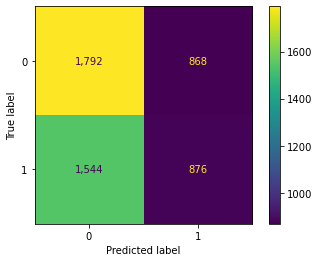

In [281]:
fn.evaluate(ada3, X_train_scaled3, X_test_scaled3, y_train3, y_test3)

### Random Forest Model with All Features

In [282]:
rf3 = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf3.fit(X_train_scaled3, y_train3)
rf_preds3 = rf3.predict(X_test_scaled3) 

Train Scores
------------
Accuracy: 0.5701909824768655
Precision: 0.5838008472602787
F1 Score: 0.38114812189936215
ROC-AUC: 0.6017098218087906
--------------------
Test Scores
-----------
Accuracy: 0.5295275590551181
Precision: 0.5242261579252009
F1 Score: 0.32562076749435664
ROC-AUC: 0.5383912259988815


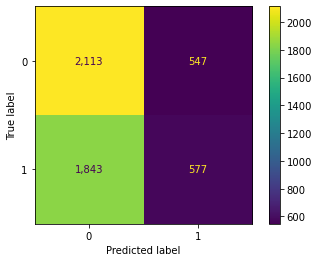

In [283]:
fn.evaluate(rf3, X_train_scaled3, X_test_scaled3, y_train3, y_test3)

### Feature Importances with All Features

The models are performing about the same with all features included. Since the random forest model seems to be performing the best (although only by about a percentage point), I'm going to use this model to try and select some of the most promising features from the set.

In [284]:
importances3 = rf3.feature_importances_

In [285]:
rf_importances3 = pd.DataFrame(index=X_test3.columns, data=importances3).sort_values(by=0,ascending=False)

In [286]:
rf_importances3

,0
FIPST,0.056994
Student_Teacher_Ratio,0.028855
Per_Pupil_Support,0.027732
State_Avg_Reading,0.026359
Total_Students,0.025134
Per_Pupil_Support_Staff,0.022630
Percent_Taxes,0.022301
Per_Pupil_Spending,0.020677
Zip_Population,0.020495
Per_Pupil_Salaries,0.018659


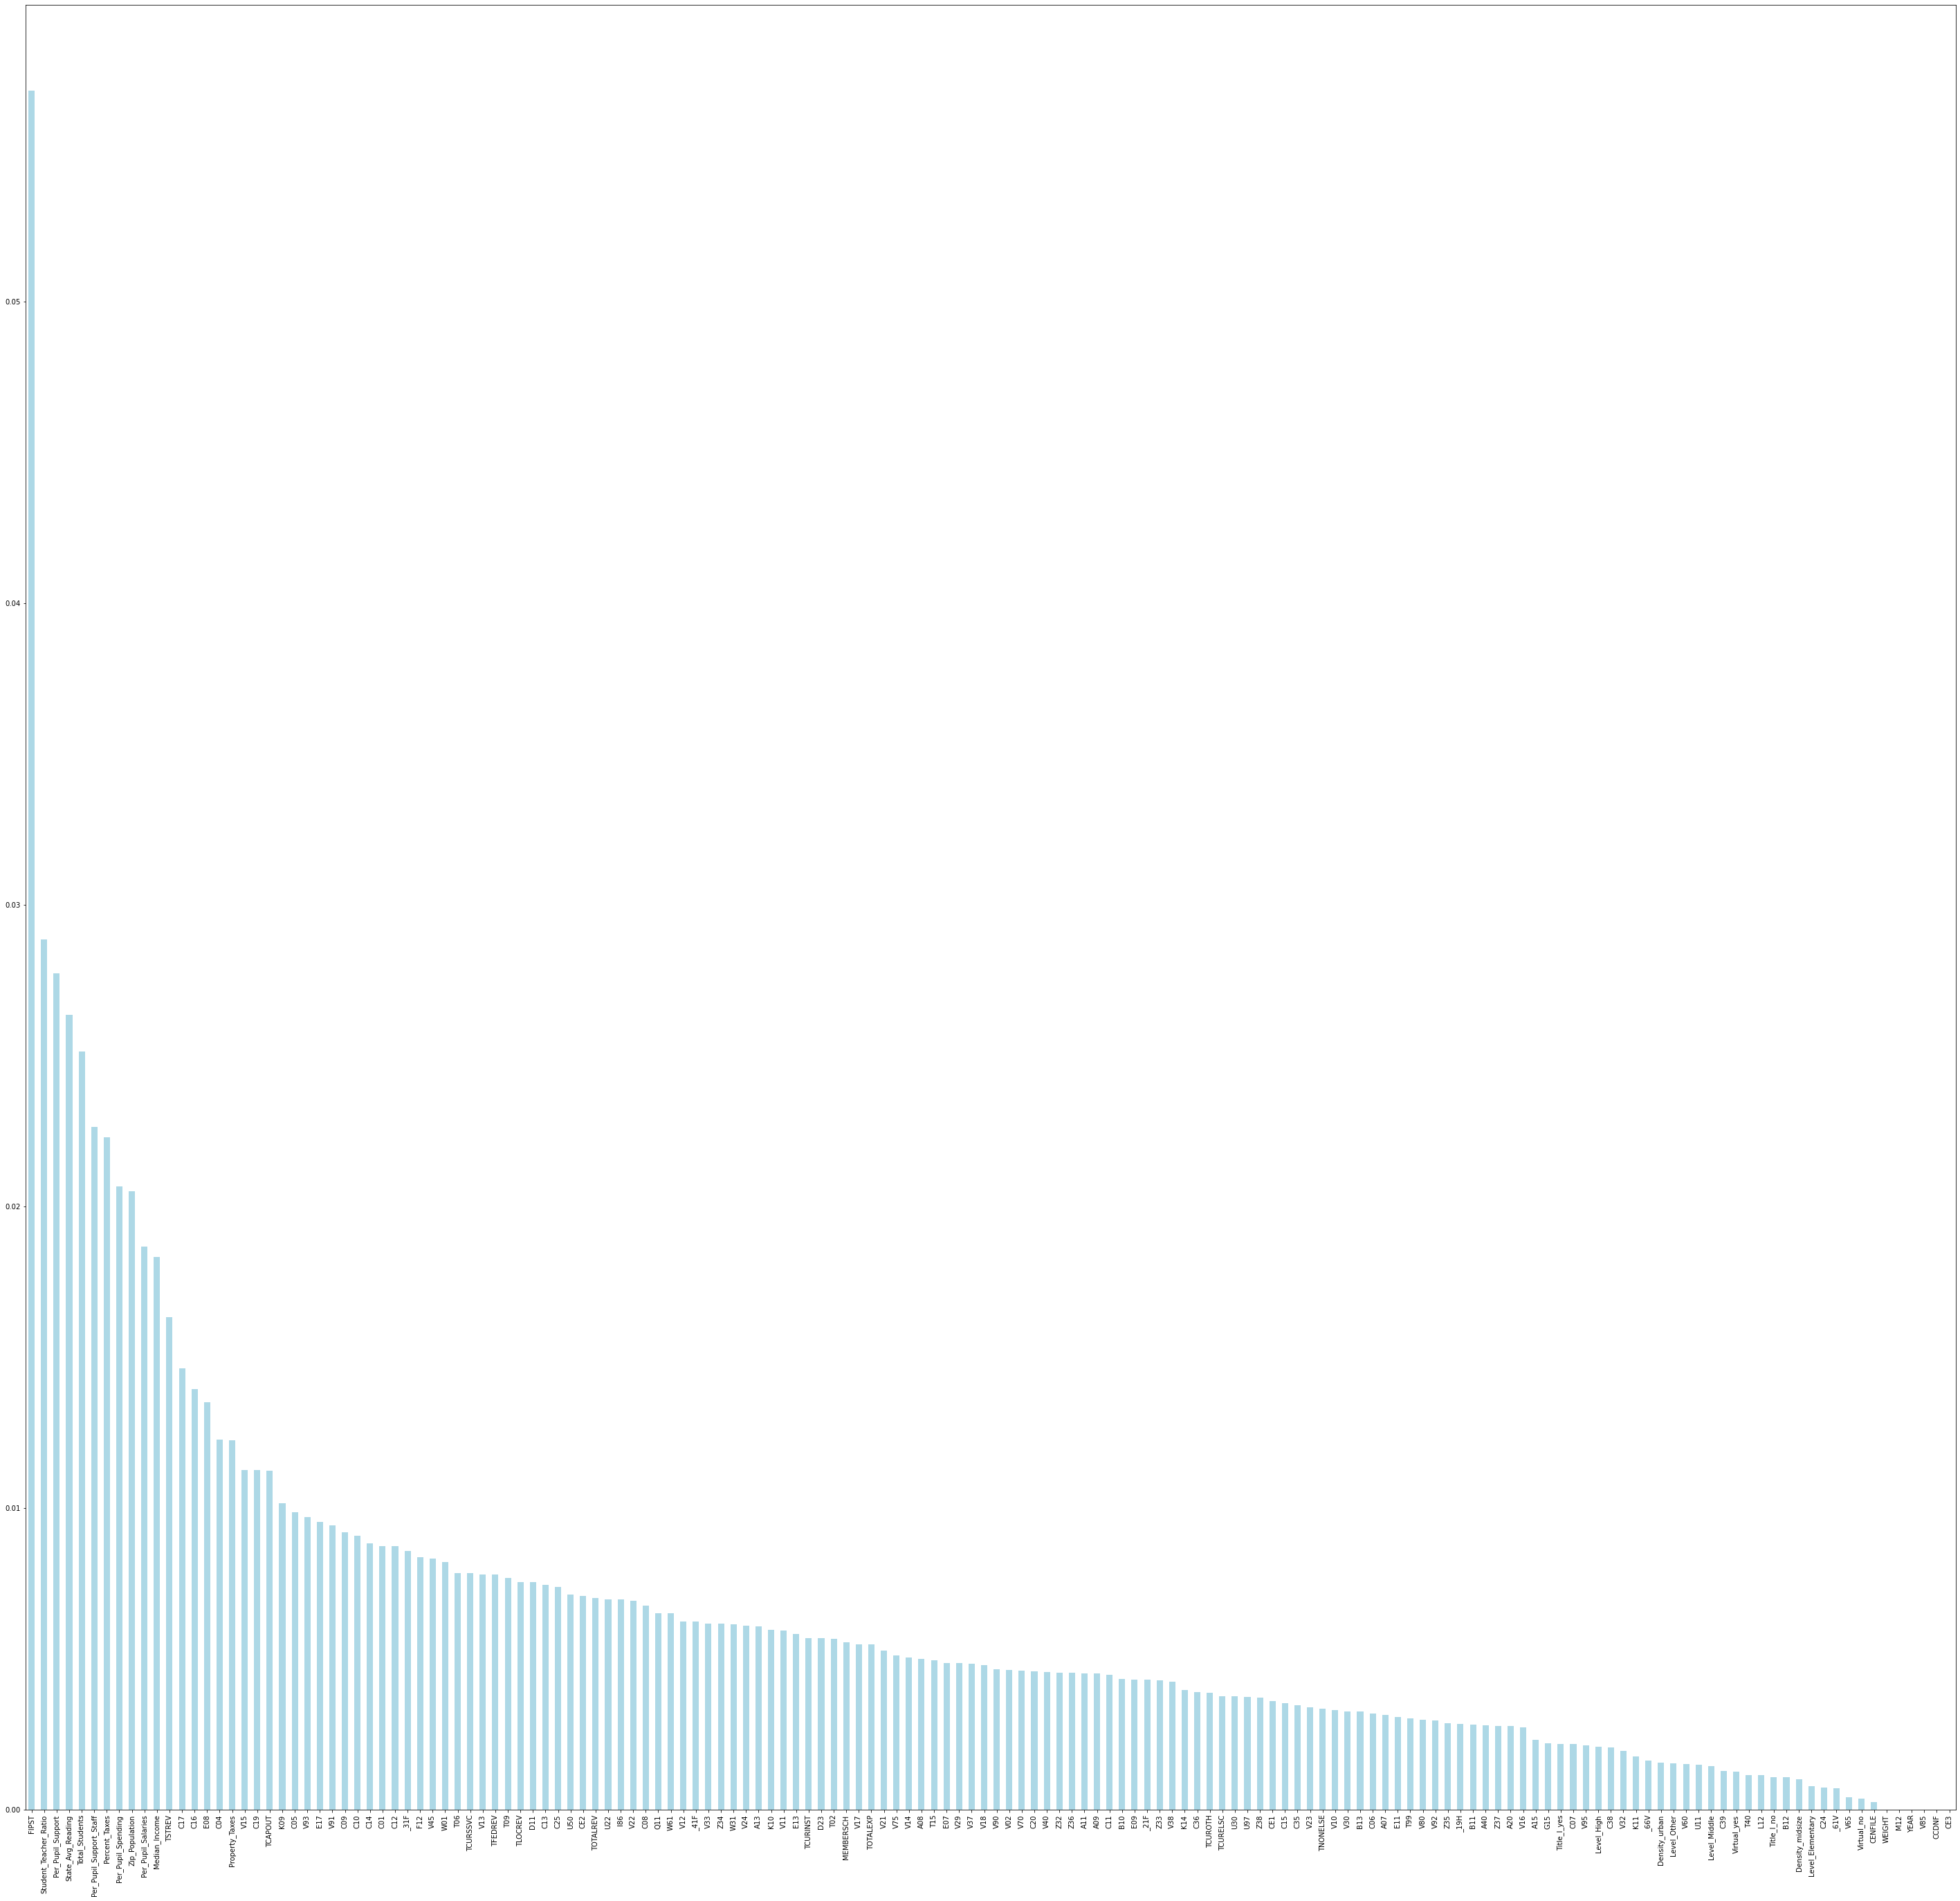

In [287]:
# plot feature importance
rf_importances3.plot(kind='bar', legend=False, color='lightblue', figsize=(50,48));

In [288]:
imp_features2 = rf_importances3.loc[rf_importances3[0] > 0.01]

In [289]:
imp_features2 = imp_features2.transpose()

In [290]:
imp_features2

,FIPST,Student_Teacher_Ratio,Per_Pupil_Support,State_Avg_Reading,Total_Students,Per_Pupil_Support_Staff,Percent_Taxes,Per_Pupil_Spending,Zip_Population,Per_Pupil_Salaries,Median_Income,TSTREV,C17,C16,E08,C04,Property_Taxes,V15,C19,TCAPOUT,K09
0,0.056994,0.028855,0.027732,0.026359,0.025134,0.02263,0.022301,0.020677,0.020495,0.018659,0.018337,0.01634,0.014636,0.01394,0.013518,0.012269,0.012258,0.011261,0.011261,0.011244,0.01017


In [291]:
importants_list = imp_features2.columns.values.tolist()

In [292]:
importants_list

['FIPST',
 'Student_Teacher_Ratio',
 'Per_Pupil_Support',
 'State_Avg_Reading',
 'Total_Students',
 'Per_Pupil_Support_Staff',
 'Percent_Taxes',
 'Per_Pupil_Spending',
 'Zip_Population',
 'Per_Pupil_Salaries',
 'Median_Income',
 'TSTREV',
 'C17',
 'C16',
 'E08',
 'C04',
 'Property_Taxes',
 'V15',
 'C19',
 'TCAPOUT',
 'K09']

In [293]:
df4 = df3[[c for c in df3.columns if c in importants_list]]

In [294]:
df4.head()

,Zip_Population,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,FIPST,C16,C17,C19,TSTREV,C04,E08,TCAPOUT,K09,V15
0,63864,41566,7637,8.7,8600,512,241,3357,206,11.31,37,4000,0,0,1506000,0,9000,18000,18000,0
1,63864,41566,2411346,24.4,15793,969,1189,5023,439,11.31,37,1305000,0,0,213378000,0,4900000,24800000,127000,3019000
2,63864,41566,15097,18.2,12453,588,825,4813,363,11.86,37,1305000,0,0,213378000,0,4900000,24800000,127000,3019000
3,63864,41566,0,46.0,14732,786,738,5595,1869,16.78,37,1305000,0,0,213378000,0,4900000,24800000,127000,3019000
4,63864,41566,0,0.0,0,0,0,0,339,10.59,37,1305000,0,0,213378000,0,4900000,24800000,127000,3019000


In [302]:
df4.shape

(25396, 20)

In [296]:
#Train-test split for final model
X_train4, X_test4, y_train4, y_test4 = train_test_split(df4, target3, test_size=0.20, random_state=42)

In [297]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled4 = scaler.fit_transform(X_train4, y=None)
X_test_scaled4 = scaler.transform(X_test4)

### Random Forest with Selected Features

In [298]:
rf4 = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf4.fit(X_train_scaled4, y_train4)
rf_preds4 = rf4.predict(X_test_scaled4) 

Train Scores
------------
Accuracy: 0.6993502658003544
Precision: 0.7001998887552309
F1 Score: 0.6918886198547215
ROC-AUC: 0.7648599997652047
--------------------
Test Scores
-----------
Accuracy: 0.6952755905511812
Precision: 0.6960533169781541
F1 Score: 0.6861313868613138
ROC-AUC: 0.7542908407382093


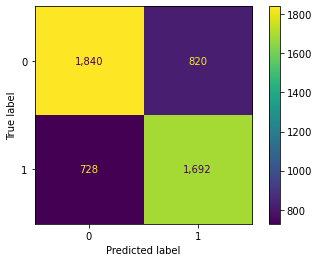

In [299]:
fn.evaluate(rf4, X_train_scaled4, X_test_scaled4, y_train4, y_test4)

### AdaBoost with Selected Features

In [300]:
ada4 = AdaBoostClassifier()
ada4.fit(X_train_scaled4, y_train4)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.6928037015160464
Precision: 0.6925795761302848
F1 Score: 0.6741502636662664
ROC-AUC: 0.7567943620174844
--------------------
Test Scores
-----------
Accuracy: 0.6893700787401574
Precision: 0.6891234239218648
F1 Score: 0.6697362913352868
ROC-AUC: 0.746894845585037


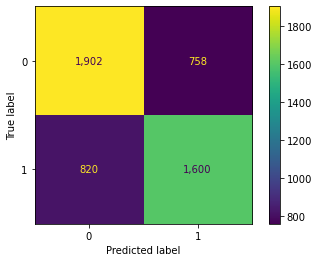

In [301]:
fn.evaluate(ada4, X_train_scaled4, X_test_scaled4, y_train4, y_test4)

In [317]:
final_model = df4.rename({'FIPST':'State','C16':'Fed$_SchoolSafety','C19':'Fed$_CTE','TSTREV':'Total_State_Revenue','C04':'State$_StaffImprove','E08':'Superint_Expenditures','TCAPOUT':'Capital_Outlay','K09':'$_Equipment','V15':'Superint_Salaries','C17':'$_SchoolSafety'}, axis=1
                         )

In [318]:
final_model.head()

,Zip_Population,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,State,Fed$_SchoolSafety,$_SchoolSafety,Fed$_CTE,Total_State_Revenue,State$_StaffImprove,Superint_Expenditures,Capital_Outlay,$_Equipment,Superint_Salaries
0,63864,41566,7637,8.7,8600,512,241,3357,206,11.31,37,4000,0,0,1506000,0,9000,18000,18000,0
1,63864,41566,2411346,24.4,15793,969,1189,5023,439,11.31,37,1305000,0,0,213378000,0,4900000,24800000,127000,3019000
2,63864,41566,15097,18.2,12453,588,825,4813,363,11.86,37,1305000,0,0,213378000,0,4900000,24800000,127000,3019000
3,63864,41566,0,46.0,14732,786,738,5595,1869,16.78,37,1305000,0,0,213378000,0,4900000,24800000,127000,3019000
4,63864,41566,0,0.0,0,0,0,0,339,10.59,37,1305000,0,0,213378000,0,4900000,24800000,127000,3019000


### Importances from Final Model

In [319]:
final_importances = rf4.feature_importances_

In [320]:
rf_importances4 = pd.DataFrame(index=final_model.columns, data=final_importances).sort_values(by=0,ascending=False)

In [321]:
rf_importances4

,0
State,0.202026
Student_Teacher_Ratio,0.163056
$_Equipment,0.120359
Superint_Salaries,0.083847
Total_State_Revenue,0.080139
Capital_Outlay,0.058783
Total_Students,0.050262
Fed$_CTE,0.049467
Fed$_SchoolSafety,0.048026
Superint_Expenditures,0.041242


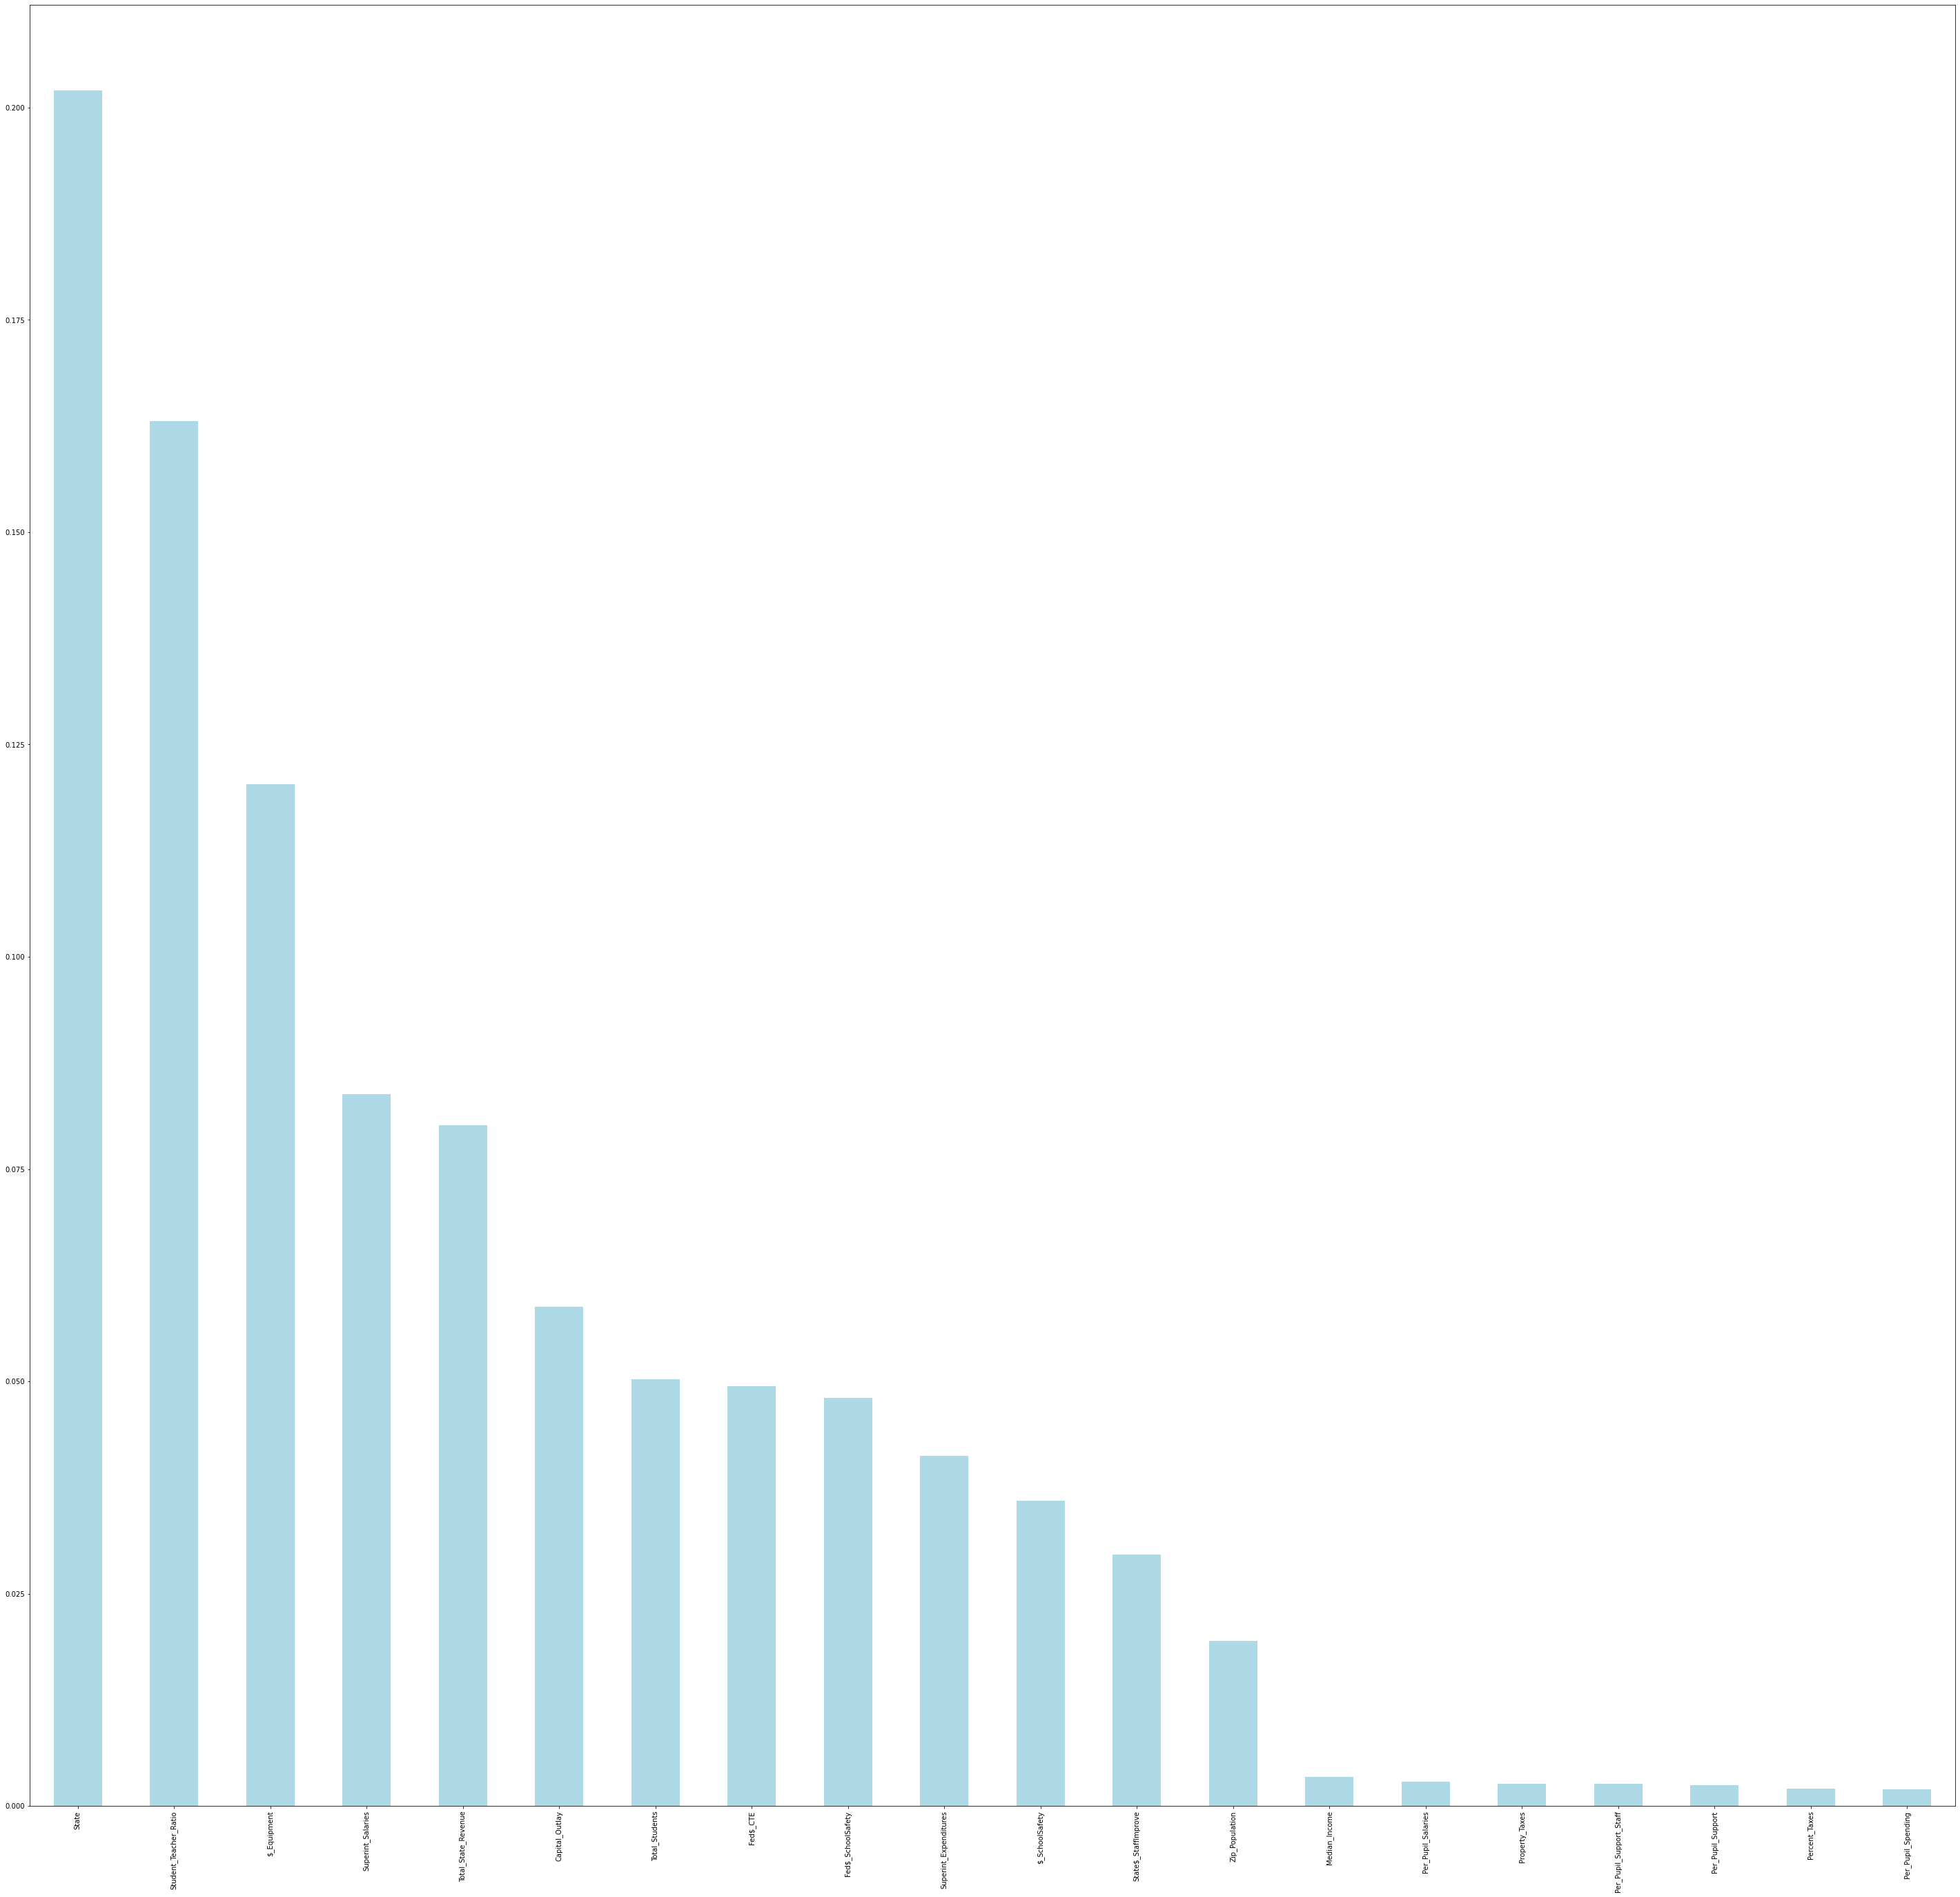

In [322]:
# plot feature importance
rf_importances4.plot(kind='bar', legend=False, color='lightblue', figsize=(50,48));